# Predicting CO2 Emission for MaunaLoa, Hawaii. (LSTM and SARIMAX)

### Mauna Loa CO2 Data

Dataset link -  https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html
Using Monthly Mean and Historical COmparison. Use Interpreted column for CO2 data.

We will derive a dataset from the Mauna Loa Observatory that collected air samples. We are interested in estimating the concentration of CO2 and extrapolate it for futher year.


In [5]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [6]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', ConvergenceWarning)

## Importing the data and making necessary changes

In [7]:
# reading the .CSV file
df_1 = pd.read_csv('co2_mm_mlo.csv')

In [8]:
# printing last 5 rows of the dataframe
df_1.tail()

,year,month,decimal_date,average,interpolated
724,2018,7,2018.542,408.71,408.71
725,2018,8,2018.625,406.99,406.99
726,2018,9,2018.708,405.51,405.51
727,2018,10,2018.792,406.00,406.00
728,2018,11,2018.875,408.02,408.02


In [9]:
# Add a "date" datetime column
df_1['date']=pd.to_datetime(dict(year=df_1['year'], month=df_1['month'], day=1))

In [10]:
# printing the dataframe after converting in to the date column
df_1.head()

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [11]:
# Set "date" to be the index
df_1.set_index('date',inplace=True)
df_1.index.freq = 'MS'
df_1.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [12]:
# assigning a different dataframe for the interpolated columns
df = df_1[['interpolated'] ]

In [13]:
df

,interpolated
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


## Visualizing the data

When working with time-series data, a lot can be revealed through visualizing it. A few things to look out for are:

seasonality: does the data display a clear periodic pattern?

trend: does the data follow a consistent upwards or downward slope?

noise: are there any outlier points or missing values that are not consistent with the rest of the data?

additive or multiplicative
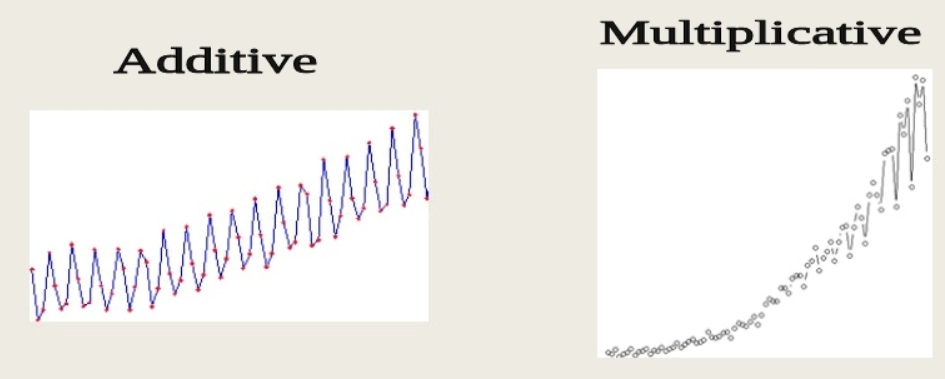

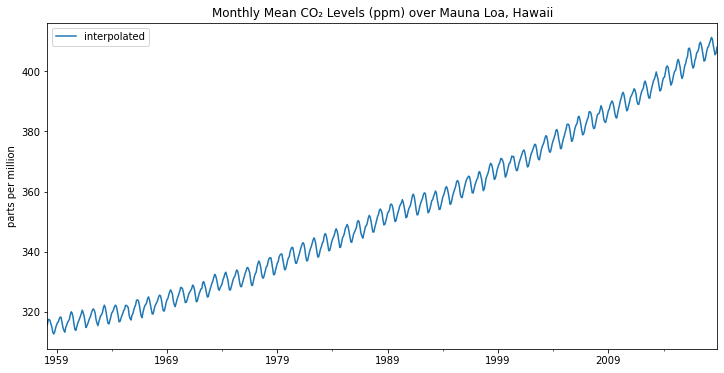

In [14]:
# plotting the actual data
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df.plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

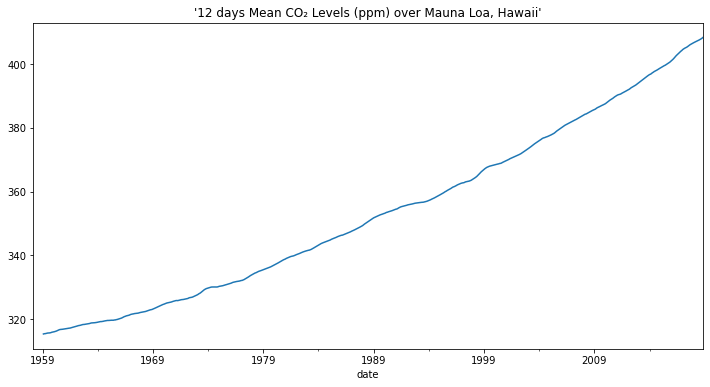

In [15]:
# plotting the rolling mean graph

plt.figure(figsize=(12,6))
df['interpolated'].rolling(window=12).mean().plot()
plt.title("'12 days Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'")
plt.show()

#### As from the above two graph we can clearly examine there is an additive trend in the Co2 levels

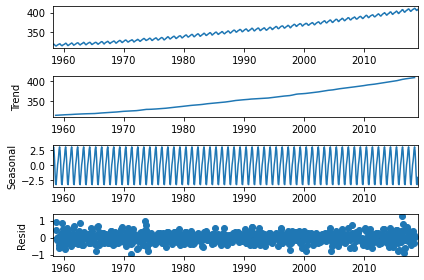

In [16]:
# Checking the timeseries decomposition to check for the seasonality and the trends
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='additive')  
result.plot()
plt.show();

Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data. The plot above clearly shows the upwards trend of our data, along with its yearly seasonality. These can be used to understand the structure of our time-series. The intuition behind time-series decomposition is important, as many forecasting methods build upon this concept of structured decomposition to produce forecasts.

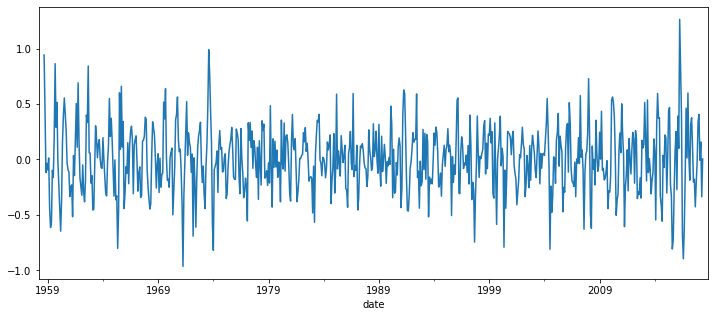

In [17]:
# checking the residuals plot for the stationarity of the data
result.resid.plot(figsize=(12,5));

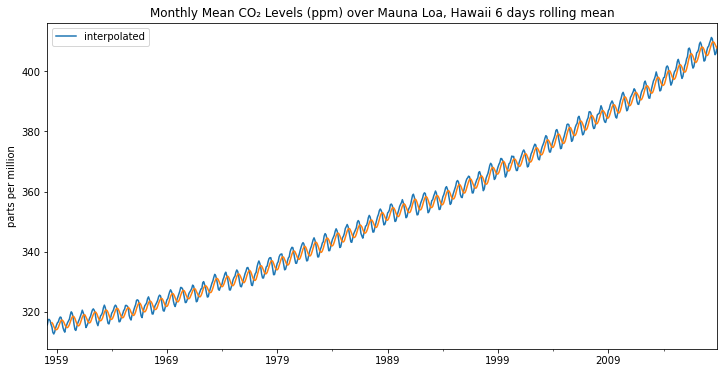

In [18]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii 6 days rolling mean'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df.plot(figsize=(12,6),title=title)
ax = df['interpolated'].rolling(window=6).mean().plot()
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

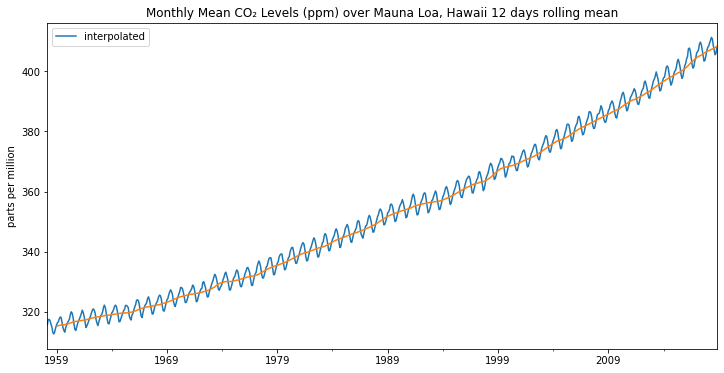

In [19]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii 12 days rolling mean'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df.plot(figsize=(12,6),title=title)
ax = df['interpolated'].rolling(window=12).mean().plot()
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [20]:
df.expanding(min_periods=20).mean()

,interpolated
date,
1958-03-01,NaN
1958-04-01,NaN
1958-05-01,NaN
1958-06-01,NaN
1958-07-01,NaN
...,...
2018-07-01,353.495683
2018-08-01,353.569366
2018-09-01,353.640812


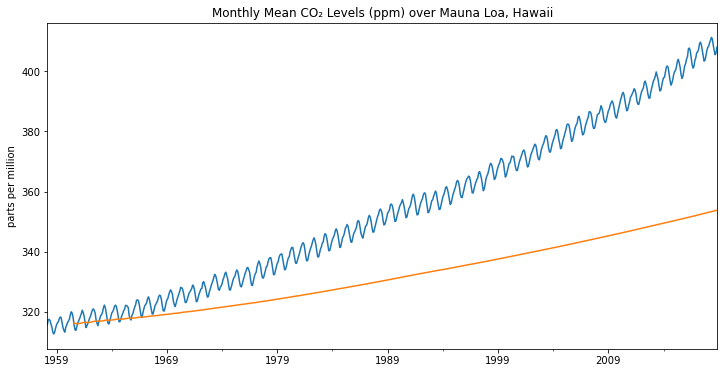

In [21]:
# 30 day expanding mean 
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'


ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax = (df['interpolated'].expanding(min_periods=30).mean()).plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show();


### AD-fuller Test For Stationarity

In [22]:
#checking for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [23]:
adf_test(df,'interpolated')

Augmented Dickey-Fuller Test: interpolated
ADF test statistic        4.994847
p-value                   1.000000
# lags used              20.000000
# observations          708.000000
critical value (1%)      -3.439620
critical value (5%)      -2.865631
critical value (10%)     -2.568948
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


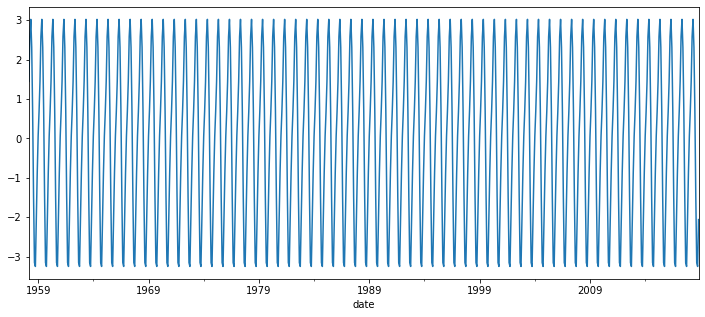

In [24]:
result.seasonal.plot(figsize=(12,5));

From the above figure we can observe that seasonality trends every 12 months

#### In our model, our parameters look like this:

#### SARIMAX (p,d,q) x (P,D,Q,s)

#### The statsmodel SARIMAX model takes into account the parameters for our regular ARIMA model (p,d,q), as well as our seasonal ARIMA model (P,D,Q,s). These sets of parameters are arguments in our model called the order and the seasonal order, respectively.

#### When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series.

#### Plotting ACF and PACF to examine parameters p(PACF) and q (ACF) in the SARIMAX model where seasonal pattern is occuring every 12 months.

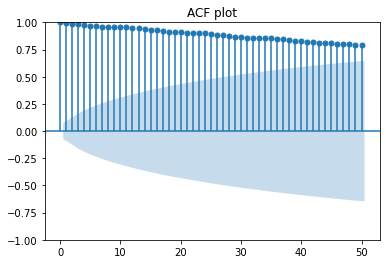

In [25]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df,title='ACF plot',lags=50)
plt.show()

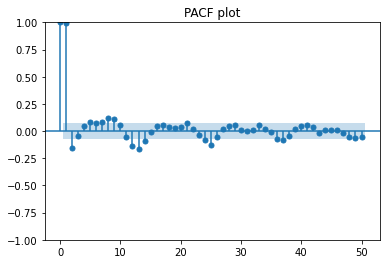

In [26]:
plot_pacf(df,title='PACF plot',lags=50)
plt.show()

### Grid Search SARIMA for best parameters 
We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let's begin by generating the various combination of parameters that we wish to assess:

In [292]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [293]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            model = sm.tsa.statespace.SARIMAX(df,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = model.fit()

            print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10617.39832828139
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10458.309970676248
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2822.1087284760238
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2377.9596231942724
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1521.8785288720678
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1516.9589115391004
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1864.3387863537014
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1357.4062887596212
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:9604.77183414494
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8519.191592468818
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2101.3642145333934
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1884.3261540885087
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1147.6708782195344
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1140.5828710363962
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1582.549183636522
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1055.355917865899
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2371.0019758047247
SARIMAX(0, 1, 0)x(0,

In [294]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

In [295]:
# fitting on the best model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -180.357
Date:                            Sat, 12 Mar 2022   AIC                            370.714
Time:                                    17:46:01   BIC                            393.498
Sample:                                03-01-1958   HQIC                           379.519
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2005      0.082      2.435      0.015       0.039       0.362
ma.L1         -0.5631      0.071     -7.911      0.000      -0.703      -0.424
ar.S.L12       0.0005      0.044      0.012      0.990      -0.086       0.087
ma.S.L12      -0.8638      0.027    -31.541      0.000      -0.917      -0.810
sigma2         0.0955      0.005     20.378      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 4.95
Prob(Q):                              0.69   Prob(JB):                         0.08
Heteroskedasticity (H):               1.13   Skew:                             0.02
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

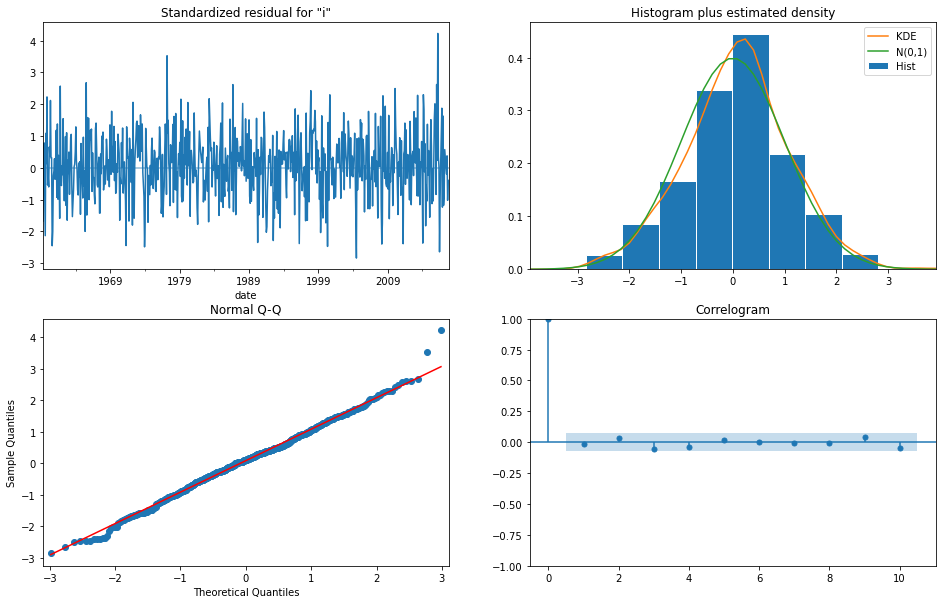

In [302]:
results.plot_diagnostics(figsize=(16,10));

In [296]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

In [297]:
test = test['interpolated']

In [298]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test[i]}")

predicted=406.60701246535143, expected=406.81
predicted=407.82478790125805, expected=407.96
predicted=408.5735945929732, expected=408.32
predicted=409.4818430646124, expected=409.41
predicted=411.04719306313154, expected=410.24
predicted=411.6526260157061, expected=411.24
predicted=410.86832210739675, expected=410.79
predicted=409.1715367518667, expected=408.71
predicted=407.06520803968414, expected=406.99
predicted=405.61115300877145, expected=405.51
predicted=405.8843377919262, expected=406.0
predicted=407.4240721728257, expected=408.02


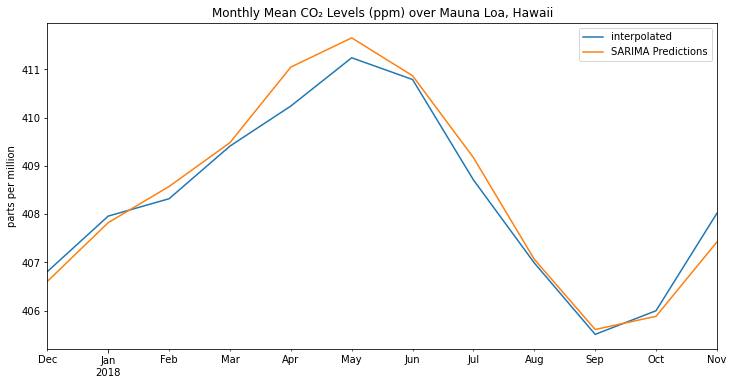

In [299]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [300]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

error = mean_squared_error(test, predictions)
print(f'SARIMA MSE Error: {error}')


error = rmse(test, predictions)
print(f'SARIMA RMSE Error: {error}')

SARIMA MSE Error: 0.1295270993514025
SARIMA RMSE Error: 0.3598987348566295


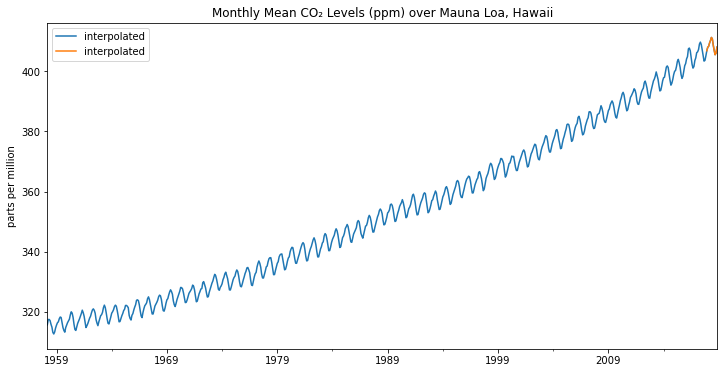

In [301]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df.plot(legend=True,figsize=(12,6),title=title)
test.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Auto Arima

In [28]:
from pmdarima import auto_arima 
auto_arima(df,seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.701
Date:                              Sat, 12 Mar 2022   AIC                            423.401
Time:                                      16:45:38   BIC                            450.943
Sample:                                           0   HQIC                           434.028
                                              - 729                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3560      0.035    -10.073      0.000      -0.425      -0.287
ma.L2         -0.0224      0.028     -0.792      0.428      -0.078       0.033
ma.L3         -0.0861      0.028     -3.042      0.002      -0.142      -0.031
ar.S.L12       0.9996      0.000   2870.137      0.000       0.999       1.000
ma.S.L12      -0.8653      0.021    -40.475      0.000      -0.907      -0.823
sigma2         0.0956      0.005     20.324      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 3.99
Prob(Q):                              0.79   Prob(JB):                         0.14
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

In [105]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train,order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.189
Date:                              Sat, 12 Mar 2022   AIC                            414.378
Time:                                      17:00:59   BIC                            441.820
Sample:                                  03-01-1958   HQIC                           424.975
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3536      0.036     -9.920      0.000      -0.423      -0.284
ma.L2         -0.0240      0.037     -0.649      0.516      -0.096       0.048
ma.L3         -0.0876      0.030     -2.965      0.003      -0.146      -0.030
ar.S.L12       0.9996      0.000   3076.618      0.000       0.999       1.000
ma.S.L12      -0.8669      0.022    -38.555      0.000      -0.911      -0.823
sigma2         0.0950      0.005     20.287      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.36
Prob(Q):                              0.77   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

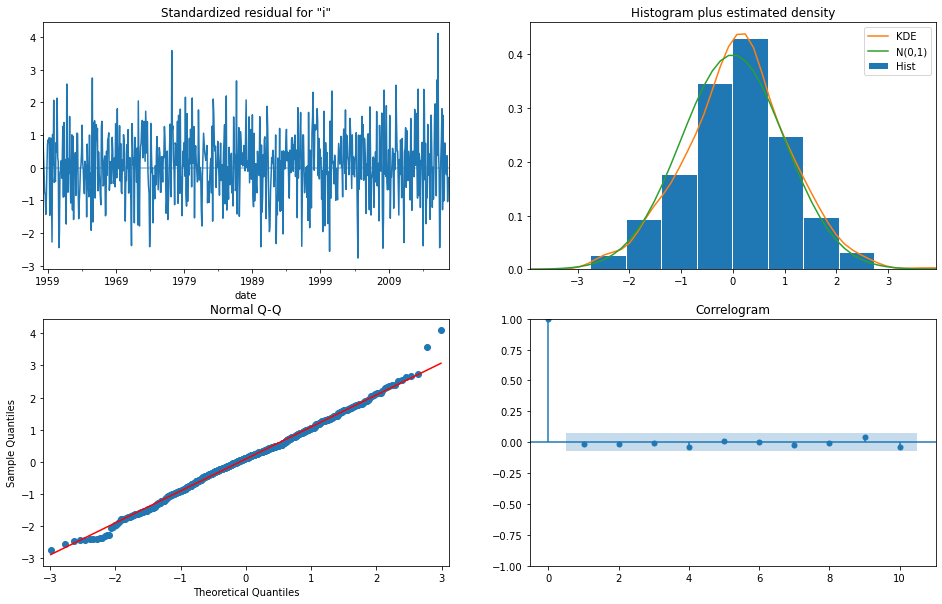

In [114]:
results.plot_diagnostics(figsize=(16,10));

In [106]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

In [107]:
predictions

2017-12-01    406.609703
2018-01-01    407.824572
2018-02-01    408.578577
2018-03-01    409.483498
2018-04-01    411.038772
2018-05-01    411.641645
2018-06-01    410.862541
2018-07-01    409.173199
2018-08-01    407.072991
2018-09-01    405.622605
2018-10-01    405.892276
2018-11-01    407.425204
Freq: MS, Name: SARIMA Predictions, dtype: float64

In [108]:
test = test['interpolated']

In [109]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test[i]}")

predicted=406.6097030639842, expected=406.81
predicted=407.8245721728567, expected=407.96
predicted=408.57857673459745, expected=408.32
predicted=409.48349774009284, expected=409.41
predicted=411.0387720049973, expected=410.24
predicted=411.6416451318503, expected=411.24
predicted=410.86254138418224, expected=410.79
predicted=409.1731986516644, expected=408.71
predicted=407.0729907252134, expected=406.99
predicted=405.62260480789826, expected=405.51
predicted=405.89227563693663, expected=406.0
predicted=407.42520445642896, expected=408.02


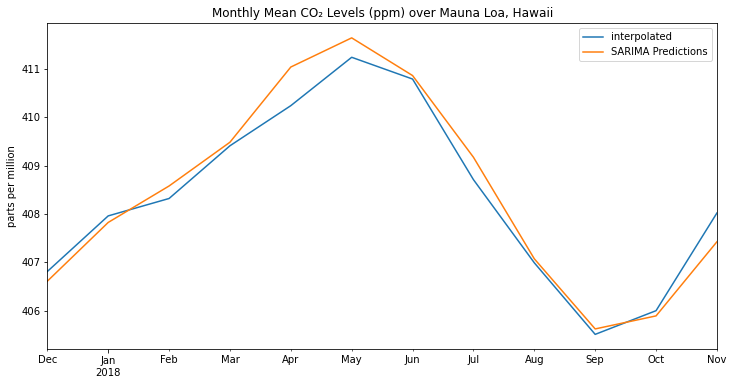

In [110]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [111]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

error = mean_squared_error(test, predictions)
print(f'SARIMA MSE Error: {error}')


error = rmse(test, predictions)
print(f'SARIMA RMSE Error: {error}')

SARIMA MSE Error: 0.12790397966064726
SARIMA RMSE Error: 0.3576366587203376


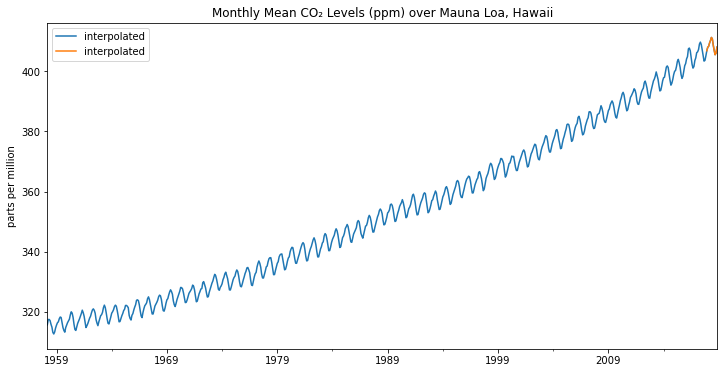

In [112]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df.plot(legend=True,figsize=(12,6),title=title)
test.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### LSTM Neural Network (Sequence to Sequence)

In [244]:
# chooing the relevant columns
df_n = df_1.drop(['year', 'month', 'decimal_date', 'average'],axis = 1)
df_n.dropna(inplace = True)
df_n.head()

,interpolated
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [245]:
# slotting train and test
train = df_n.iloc[:700]
test = df_n.iloc[700:]

In [246]:
#scaling the data for the NN to perform well
from sklearn.preprocessing import MinMaxScaler

# initiating the scalar
scaler = MinMaxScaler()

#fitting on the train data
scaler.fit(train)

# transforming train and test data
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### (input)[T1,T2,T3] ----> [T4](predict)

so as the LSTM works, we need to transform our data in to this format where we have multiple input.

we can do this automatically by using Keras Time series generator

## Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [248]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [249]:
# creating an instance for the time series ganerator
n_input = 12 #how many X's you want to feed (if see the seasonality then choose that number in this case it is 12)
n_features = 1
train_generator = TimeseriesGenerator(scaled_train,# we are feeding scaled_train two times becoz we want both input and Output as scaled train
                                scaled_train,
                                length= n_input,
                                batch_size= 1
                               ) 

In [250]:
len(scaled_train)

700

In [251]:
# as we are creating a input of 12. so, there wont be first 12 observations hence 700-12 = 688 
len(train_generator)

688

In [252]:
# checking out the first row
input_, output_ = train_generator[0] # observe first item in the generator for n_input = 3

In [256]:
print(f'Given the Array: \n{input_.flatten()}')
print(f'Predict this y: \n {output_}')

Given the Array: 
[0.032085   0.05038923 0.05091521 0.04670734 0.03366295 0.02387965
 0.00568062 0.         0.00704818 0.02114454 0.03113823 0.03913318]
Predict this y: 
 [[0.04260467]]


In [257]:
# importing necessary modules
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [258]:
# define model
model = Sequential()
# adding an lstm layer
model.add(LSTM(150, activation='relu',input_shape=(n_input, n_features)))
# output layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [259]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 150)               91200     
                                                                 
 dense_10 (Dense)            (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [260]:
# fitting the model on training data
model.fit_generator(train_generator,epochs = 50)

Epoch 1/50
688/688 [==============================] - 4s 4ms/step - loss: 0.0067
Epoch 2/50
688/688 [==============================] - 3s 4ms/step - loss: 0.0011
Epoch 3/50
688/688 [==============================] - 3s 4ms/step - loss: 0.0013
Epoch 4/50
688/688 [==============================] - 3s 4ms/step - loss: 9.6479e-04
Epoch 5/50
688/688 [==============================] - 3s 4ms/step - loss: 8.7766e-04
Epoch 6/50
688/688 [==============================] - 3s 4ms/step - loss: 8.3796e-04
Epoch 7/50
688/688 [==============================] - 3s 4ms/step - loss: 8.8943e-04
Epoch 8/50
688/688 [==============================] - 3s 4ms/step - loss: 6.5475e-04
Epoch 9/50
688/688 [==============================] - 3s 4ms/step - loss: 9.9754e-04
Epoch 10/50
688/688 [==============================] - 3s 4ms/step - loss: 5.0782e-04
Epoch 11/50
688/688 [==============================] - 3s 4ms/step - loss: 3.7783e-04
Epoch 12/50
688/688 [==============================] - 3s 4ms/step - loss: 

In [262]:
model.history.history.keys()

dict_keys(['loss'])

In [263]:
model.history.history['loss']

[0.006664901971817017,
 0.0011128720361739397,
 0.0012651766883209348,
 0.0009647893602959812,
 0.0008776551112532616,
 0.0008379646460525692,
 0.0008894306374713778,
 0.0006547486991621554,
 0.0009975379798561335,
 0.0005078226677142084,
 0.0003778301179409027,
 0.00038246458279900253,
 0.0002080332051264122,
 0.00020334369037300348,
 0.00020014001347590238,
 9.266167762689292e-05,
 0.00017681490862742066,
 0.00016180664533749223,
 0.00010929984273388982,
 7.434774306602776e-05,
 0.00012166203669039533,
 0.00012118384620407596,
 0.0001318105059908703,
 7.992384780663997e-05,
 9.171706187771633e-05,
 8.411145972786471e-05,
 0.0002484029100742191,
 6.600699271075428e-05,
 7.830053073121235e-05,
 8.490650361636654e-05,
 4.712534064310603e-05,
 7.986195851117373e-05,
 5.832393071614206e-05,
 6.309167656581849e-05,
 0.00011242149776080623,
 4.7869129048194736e-05,
 0.00010418109741294757,
 6.131616828497499e-05,
 6.57241398585029e-05,
 6.147864769445732e-05,
 5.384101314120926e-05,
 5.6128

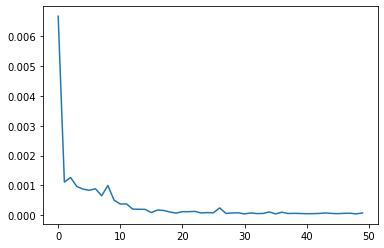

In [264]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### Evaluate the model

so, in this case we are taking last 12 as input and predicting the 13th data


In [265]:
first_eval_batch = scaled_train[-12:]

In [266]:
first_eval_batch

array([[0.9325689 ],
       [0.90753208],
       [0.89385651],
       [0.9007995 ],
       [0.92047128],
       [0.93824953],
       [0.94571849],
       [0.96212918],
       [0.97001894],
       [0.99715969],
       [1.        ],
       [0.99063749]])

we need to match the shape as we input the shape as we generated in the generator

In [269]:
first_eval_batch.reshape((1,n_input,n_features))

array([[[0.9325689 ],
        [0.90753208],
        [0.89385651],
        [0.9007995 ],
        [0.92047128],
        [0.93824953],
        [0.94571849],
        [0.96212918],
        [0.97001894],
        [0.99715969],
        [1.        ],
        [0.99063749]]])

input last 12 data points from the training set and we get the predicted values

In [270]:
model.predict(first_eval_batch.reshape((1,n_input,n_features)))

array([[0.96914357]], dtype=float32)

In [271]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [272]:
current_batch.shape

(1, 12, 1)

In [273]:
current_batch

array([[[0.9325689 ],
        [0.90753208],
        [0.89385651],
        [0.9007995 ],
        [0.92047128],
        [0.93824953],
        [0.94571849],
        [0.96212918],
        [0.97001894],
        [0.99715969],
        [1.        ],
        [0.99063749]]])

In [274]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 0.90753208],
        [ 0.89385651],
        [ 0.9007995 ],
        [ 0.92047128],
        [ 0.93824953],
        [ 0.94571849],
        [ 0.96212918],
        [ 0.97001894],
        [ 0.99715969],
        [ 1.        ],
        [ 0.99063749],
        [99.        ]]])

In [275]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [276]:
test_predictions

[array([0.96914357], dtype=float32),
 array([0.9403161], dtype=float32),
 array([0.91414475], dtype=float32),
 array([0.9036855], dtype=float32),
 array([0.91440004], dtype=float32),
 array([0.9290851], dtype=float32),
 array([0.9374931], dtype=float32),
 array([0.94314903], dtype=float32),
 array([0.9482788], dtype=float32),
 array([0.9529681], dtype=float32),
 array([0.9579168], dtype=float32),
 array([0.9630541], dtype=float32),
 array([0.9631599], dtype=float32),
 array([0.95723116], dtype=float32),
 array([0.9489827], dtype=float32),
 array([0.9428683], dtype=float32),
 array([0.94126964], dtype=float32),
 array([0.9453477], dtype=float32),
 array([0.9537789], dtype=float32),
 array([0.96220326], dtype=float32),
 array([0.968354], dtype=float32),
 array([0.9737272], dtype=float32),
 array([0.97913826], dtype=float32),
 array([0.9833673], dtype=float32),
 array([0.98528254], dtype=float32),
 array([0.98516655], dtype=float32),
 array([0.9820622], dtype=float32),
 array([0.97772914]

In [277]:
scaled_test

array([[0.96517989],
       [0.94266779],
       [0.92983379],
       [0.93551441],
       [0.95613297],
       [0.96560067],
       [0.98369451],
       [0.98674521],
       [0.99474016],
       [1.01388597],
       [1.02072375],
       [1.01220282],
       [0.9936882 ],
       [0.97275405],
       [0.95423943],
       [0.95697454],
       [0.97264885],
       [0.9904271 ],
       [1.00252472],
       [1.0063118 ],
       [1.01777825],
       [1.02650957],
       [1.03702924],
       [1.03229539],
       [1.01041448],
       [0.99232064],
       [0.97675153],
       [0.98190616],
       [1.0031559 ]])

### Inverse Transform  the predictions so that we can compare the accuracy

In [278]:
true_predictions = scaler.inverse_transform(test_predictions)

In [279]:
true_predictions

array([[404.78678771],
       [402.04644666],
       [399.55860035],
       [398.5643446 ],
       [399.58286791],
       [400.97882731],
       [401.77809274],
       [402.31574681],
       [402.80338128],
       [403.24914954],
       [403.71957065],
       [404.2079247 ],
       [404.21798188],
       [403.65439445],
       [402.87029695],
       [402.28905987],
       [402.13709161],
       [402.52475487],
       [403.32622438],
       [404.1270423 ],
       [404.71172998],
       [405.22251013],
       [405.73688253],
       [406.13889781],
       [406.32095828],
       [406.30993221],
       [406.01483469],
       [405.60293221],
       [405.33380204]])

In [280]:
test

,interpolated
date,
2016-07-01,404.41
2016-08-01,402.27
2016-09-01,401.05
2016-10-01,401.59
2016-11-01,403.55
2016-12-01,404.45
2017-01-01,406.17
2017-02-01,406.46
2017-03-01,407.22


In [281]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [282]:
test

,interpolated,Predictions
date,,
2016-07-01,404.41,404.786788
2016-08-01,402.27,402.046447
2016-09-01,401.05,399.558600
2016-10-01,401.59,398.564345
2016-11-01,403.55,399.582868
2016-12-01,404.45,400.978827
2017-01-01,406.17,401.778093
2017-02-01,406.46,402.315747
2017-03-01,407.22,402.803381


<AxesSubplot:xlabel='date'>

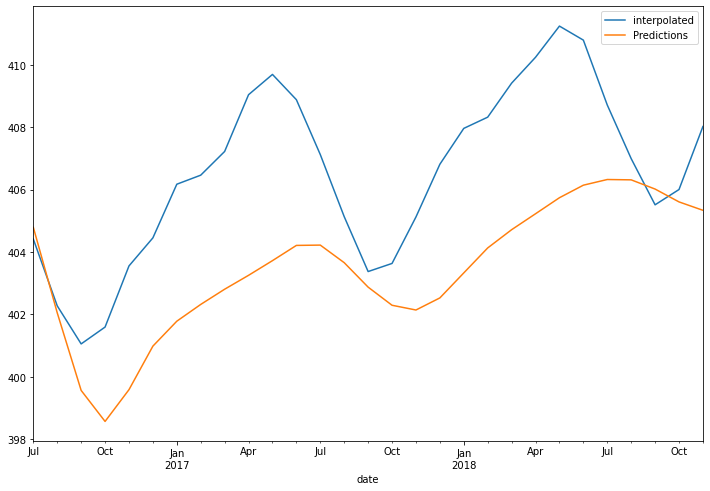

In [283]:
test.plot(figsize=(12,8))

In [289]:
error = mean_squared_error(test['interpolated'], test['Predictions'])
print(f'LSTM MSE Error: {error}')


error = rmse(test['interpolated'], test['Predictions'])
print(f'LSTM RMSE Error: {error}')

LSTM MSE Error: 13.043497562428934
LSTM RMSE Error: 3.6115782647519814


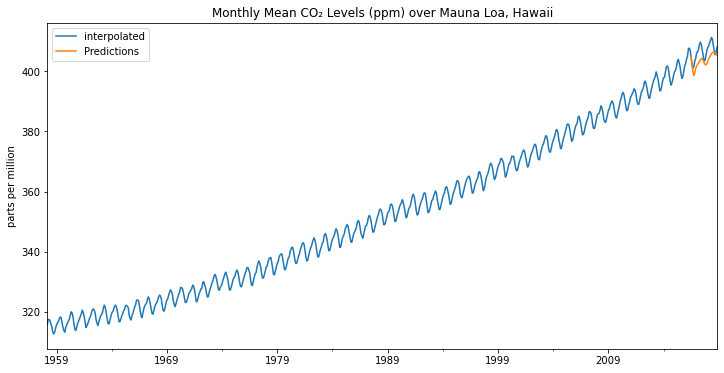

In [291]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'

ax = df.plot(legend=True,figsize=(12,6),title=title)
test['Predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

##### Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

https://machinelearningmastery.com/different-results-each-time-in-machine-learning/


## Conclusion
#### In this tutorial, we described how to implement a seasonal ARIMA model in Python. We made extensive use of the pandas and statsmodels libraries and showed how to run model diagnostics, as well as how to produce forecasts of the CO2 time series. even though SARIMA performed well in our case. we need to fine tune LSTM model for furthur the analysis.
